In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import time

import numpy as np
import matplotlib.pyplot as plt
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers


import warnings 
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

train_path_en = "/content/drive/MyDrive/train.lc.norm.tok.en"
train_path_de = "/content/drive/MyDrive/train.lc.norm.tok.de"
test_path_en = "/content/drive/MyDrive/test_2017_flickr.lc.norm.tok.en"
test_path_de = "/content/drive/MyDrive/test_2017_flickr.lc.norm.tok.de"

In [2]:
train_path_en = "train.lc.norm.tok.en"
train_path_de = "train.lc.norm.tok.de"
test_path_en = "test_2017_flickr.lc.norm.tok.en"
test_path_de = "test_2017_flickr.lc.norm.tok.de"

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
with open(train_path_en) as en_raw_train:
    en_train = en_raw_train.readlines()
with open(train_path_de) as de_raw_train:
    de_train = de_raw_train.readlines()
with open(test_path_en) as en_raw_test:
    en_test = en_raw_test.readlines()
with open(test_path_de) as de_raw_test:
    de_test = de_raw_test.readlines()

In [5]:
print(len(en_train))
print(len(de_train))
print(len(en_test))
print(len(de_test))

29000
29000
1000
1000


In [6]:
for i in range(5):
    print('German', de_train[i].strip())
    print('English:', en_train[i].strip())
    

German zwei junge weiße männer sind im freien in der nähe vieler büsche .
English: two young , white males are outside near many bushes .
German mehrere männer mit schutzhelmen bedienen ein antriebsradsystem .
English: several men in hard hats are operating a giant pulley system .
German ein kleines mädchen klettert in ein spielhaus aus holz .
English: a little girl climbing into a wooden playhouse .
German ein mann in einem blauen hemd steht auf einer leiter und putzt ein fenster .
English: a man in a blue shirt is standing on a ladder cleaning a window .
German zwei männer stehen am herd und bereiten essen zu .
English: two men are at the stove preparing food .


# Text Preprocessing

In [7]:
en_train = [sent.strip().split(" ") for sent in en_train] 
en_test = [sent.strip().split(" ") for sent in en_test]

de_train = [sent.strip().split(" ") for sent in de_train]
de_test = [sent.strip().split(" ") for sent in de_test]

In [8]:
en_index2word = ["<PAD>", "<SOS>", "<EOS>"]
de_index2word = ["<PAD>", "<SOS>", "<EOS>"]

for data in [en_train, en_test]:
    for i in data:
        for token in i:
            if token not in en_index2word:
                en_index2word.append(token)

en_index2word[:10]

['<PAD>',
 '<SOS>',
 '<EOS>',
 'two',
 'young',
 ',',
 'white',
 'males',
 'are',
 'outside']

In [9]:
for data in [de_train, de_test]:
    for i in data:
        for token in i:
            if token not in de_index2word:
                de_index2word.append(token)
                
de_index2word[:10]

['<PAD>',
 '<SOS>',
 '<EOS>',
 'zwei',
 'junge',
 'weiße',
 'männer',
 'sind',
 'im',
 'freien']

In [10]:
en_word2index = {t: index for index, t in enumerate(en_index2word)}
de_word2index = {t: index for index, t in enumerate(de_index2word)}

In [11]:
en_len = sum([len(i) for i in en_train])/len(en_train)
de_len = sum([len(i) for i in de_train])/len(de_train)

In [12]:
print('Mean length of english sentences', en_len)

Mean length of english sentences 13.018448275862069


In [13]:
print('Mean length of german sentences', de_len)

Mean length of german sentences 12.438137931034483


In [14]:
seq_length = 25

In [15]:
def encode_and_pad(vocab, sent, seq_length):
    sos = [vocab["<SOS>"]]
    eos = [vocab["<EOS>"]]
    pad = [vocab["<PAD>"]]

    if len(sent) < seq_length - 2: # -2 to include SOS and EOS
        n_pads = seq_length - 2 - len(sent)
        encoded = [vocab[w] for w in sent]
        return sos + encoded + eos + pad * n_pads  # add padding
    
    else: # if sentence is longer, then truncate
        encoded = [vocab[w] for w in sent]
        truncated = encoded[:seq_length - 2]
        return sos + truncated + eos

In [16]:
#Encode and pad training data
train_y = np.array([encode_and_pad(en_word2index, i, seq_length) for i in en_train])
train_x = np.array([encode_and_pad(de_word2index, i, seq_length) for i in de_train])


# Encode and pad testing data
test_y = np.array([encode_and_pad(en_word2index, i, seq_length) for i in en_test])
test_x = np.array([encode_and_pad(de_word2index, i, seq_length) for i in de_test])

In [17]:
#Converting to tensor dataset

batch_size = 256

train_ds = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
test_ds = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))


trainloader = DataLoader(train_ds, shuffle = True, batch_size = batch_size, drop_last = True)
testloader = DataLoader(test_ds, shuffle = True, batch_size = batch_size, drop_last = True)

In [18]:
for x, y in trainloader:
    print(x.shape, y.shape)
    break

torch.Size([256, 25]) torch.Size([256, 25])


In [19]:
for x, y in trainloader:
    print(x)
    break

tensor([[    1,    20, 18162,  ...,     0,     0,     0],
        [    1,    65,    68,  ...,     0,     0,     0],
        [    1,    20,     4,  ...,     0,     0,     0],
        ...,
        [    1,  5994,    17,  ...,     0,     0,     0],
        [    1,    20,    28,  ...,     0,     0,     0],
        [    1,    20,    28,  ...,     0,     0,     0]])


# Model Building

In [20]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # Embedding layer
        self.embedding = nn.Embedding(input_size, hidden_size, padding_idx=0)
        
        # GRU layer
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

    def forward(self, input, hidden):
        
        # Transform input to embedding
        output = self.embedding(input)

        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        # This method is used to create the innitial hidden states for the encoder
        return torch.zeros(1, batch_size, self.hidden_size)

In [21]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        # Embedding layer
        self.embedding = nn.Embedding(output_size, hidden_size, padding_idx=0)
        # GRU layer
        self.gru = nn.GRU(hidden_size, hidden_size)
        # Linear layer
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):

        # Transform input to embedding
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]))
        
        return output, hidden

In [22]:
hidden_size = 1200

In [23]:
encoder = EncoderRNN(len(de_index2word), hidden_size).to(device)
decoder = DecoderRNN(hidden_size, len(en_index2word)).to(device)

In [24]:
encoder

EncoderRNN(
  (embedding): Embedding(19138, 1200, padding_idx=0)
  (gru): GRU(1200, 1200, batch_first=True)
)

In [25]:
decoder

DecoderRNN(
  (embedding): Embedding(10395, 1200, padding_idx=0)
  (gru): GRU(1200, 1200)
  (out): Linear(in_features=1200, out_features=10395, bias=True)
)

In [26]:
criterion = nn.CrossEntropyLoss()
enc_optimizer = torch.optim.Adam(encoder.parameters(), lr = 0.001)
dec_optimizer = torch.optim.Adam(decoder.parameters(), lr = 0.001)

In [27]:
epochs = 35
train_loss = []
losses = []

for epoch in range(epochs):
    start_time = time.time()
    
    for german, english in trainloader:

        encoder_hidden = encoder.initHidden() 
        encoder_hidden = encoder_hidden.to(device)
        input_tensor = german.to(device)
        target_tensor = english.to(device)
        
        enc_optimizer.zero_grad()
        dec_optimizer.zero_grad()

        # Enabling gradient calculation
        with torch.set_grad_enabled(True):
            
            # Encoding
            encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)

            # Decoder placeholder
            dec_result = torch.zeros(seq_length, batch_size, len(en_index2word)).to(device)

            # Creating a batch of SOS tokens which will all be fed to the decoder
            dec_input = target_tensor[:, 0].unsqueeze(dim=0).to(device)

            # Hidden states of decoder will be the same as encoder's final hidden state
            decoder_hidden = encoder_hidden

            # Decoding
            for i in range(1, seq_length):
                
                decoder_output, decoder_hidden = decoder(dec_input, decoder_hidden)
                pred = decoder_output.argmax(1)
                decoder_input = pred.unsqueeze(dim=0) 
                #assigning the prediction to decoder result
                dec_result[i] = decoder_output


            # Creating scores and targets for loss calculation
            scores = dec_result.transpose(1, 0)[1:].reshape(-1, dec_result.shape[2])
            targets = target_tensor[1:].reshape(-1)

            # Calculating loss and back propagating
            loss = criterion(scores, targets)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1)
            torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1)

            enc_optimizer.step()
            dec_optimizer.step()

            losses.append(loss.item())
            
    end_time = time.time()
    train_loss.append(np.mean(losses))      
    print((f"Epoch: {epoch}, Train loss: {np.mean(losses):.3f} "
           f"Epoch time = {(end_time - start_time):.3f}s"))

    

Epoch: 0, Train loss: 3.467 Epoch time = 845.308s
Epoch: 1, Train loss: 3.163 Epoch time = 632.948s
Epoch: 2, Train loss: 2.970 Epoch time = 651.194s
Epoch: 3, Train loss: 2.818 Epoch time = 641.292s
Epoch: 4, Train loss: 2.689 Epoch time = 631.372s
Epoch: 5, Train loss: 2.578 Epoch time = 637.275s
Epoch: 6, Train loss: 2.483 Epoch time = 650.433s
Epoch: 7, Train loss: 2.395 Epoch time = 629.560s
Epoch: 8, Train loss: 2.316 Epoch time = 633.246s
Epoch: 9, Train loss: 2.247 Epoch time = 633.885s
Epoch: 10, Train loss: 2.182 Epoch time = 649.839s
Epoch: 11, Train loss: 2.123 Epoch time = 642.336s
Epoch: 12, Train loss: 2.070 Epoch time = 643.704s
Epoch: 13, Train loss: 2.020 Epoch time = 636.710s
Epoch: 14, Train loss: 1.974 Epoch time = 646.474s
Epoch: 15, Train loss: 1.931 Epoch time = 636.402s
Epoch: 16, Train loss: 1.891 Epoch time = 636.428s
Epoch: 17, Train loss: 1.853 Epoch time = 635.670s
Epoch: 18, Train loss: 1.817 Epoch time = 634.728s
Epoch: 19, Train loss: 1.783 Epoch time =

Text(0.5, 1.0, 'Training Loss')

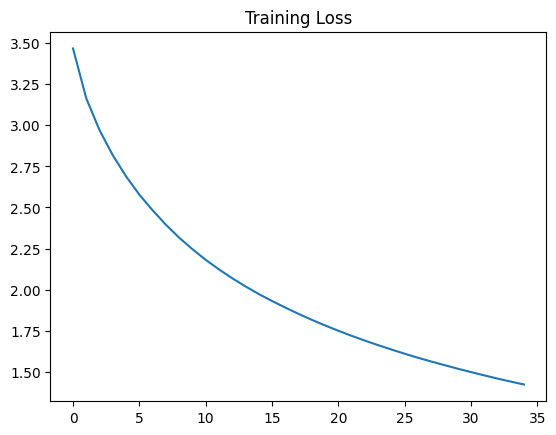

In [28]:
plt.plot(train_loss)
plt.title('Training Loss')

# Decoding

### Predicting for some 5 samples

In [42]:
x = [50, 92, 5, 49, 98, 80]

print(x)

[50, 92, 5, 49, 98, 80]


In [43]:
with open(test_path_de) as de_raw_test:
    de_test_parsed = de_raw_test.readlines()
    
with open(test_path_en) as en_raw_test:
    en_test_parsed = en_raw_test.readlines()    

In [68]:
SOS = de_word2index["<SOS>"]
EOS = de_word2index["<EOS>"]

english_text = []
for j in x:
    test_sentence = de_test_parsed[j].strip()

    # Tokenizing and encodingthe text data
    test_sentence = torch.tensor(encode_and_pad(de_word2index, test_sentence.split(), seq_length)).unsqueeze(dim=0)

    encoder_hidden = torch.zeros(1, 1, hidden_size)
    encoder_hidden = encoder_hidden.to(device)

    input_tensor = test_sentence.to(device)

    enc_optimizer.zero_grad()
    dec_optimizer.zero_grad()

    result = []

    encoder_outputs = torch.zeros(seq_length, encoder.hidden_size, device=device)

    with torch.set_grad_enabled(False):
        
        # Encoding and decoding the text data
        encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)
        dec_result = torch.zeros(seq_length, 1, len(en_index2word)).to(device)
        dec_input = torch.tensor([SOS]).unsqueeze(dim=0).to(device)
        decoder_hidden = encoder_hidden
        
        #decoding
        for i in range(1, seq_length):
            decoder_output, decoder_hidden = decoder(dec_input, decoder_hidden)
            pred = decoder_output.argmax(1)

            # decoding until we find end of string
            if pred.item() == EOS or pred.item() == 0:
                break
  
            result.append(en_index2word[pred.to('cpu').item()])
            decoder_input = pred.unsqueeze(dim=0) 
            dec_result[i] = decoder_output

        scores = dec_result.reshape(-1, dec_result.shape[2])
        targets = target_tensor.reshape(-1)
        
    print(" ".join(result))
    english_text.append(" ".join(result))

a dog runs on on a beach .
two people in bathing are enjoying on the .
a man and a woman walking in the . .
a is walking through the woods .
an old man sitting on while on his train phone .
a surfer rides a large wave .


In [69]:
for i in range(6):
    print("Actual: {} \n Predicted: {} \n".format(en_test_parsed[x[i]].strip(), english_text[i].strip()))

Actual: a dog is running on a beach . 
 Predicted: a dog runs on on a beach . 

Actual: two people in kayaks on the water . 
 Predicted: two people in bathing are enjoying on the . 

Actual: a man and a woman walking in the city 
 Predicted: a man and a woman walking in the . . 

Actual: a woman is walking through the woods . 
 Predicted: a is walking through the woods . 

Actual: an old man talking on the phone sitting on a bench 
 Predicted: an old man sitting on while on his train phone . 

Actual: a surfer rides a big wave . 
 Predicted: a surfer rides a large wave . 



In [70]:
ip_test = []
for i in range(6):
    ip_test.append(en_test_parsed[x[i]].strip())

In [71]:
result_df = pd.DataFrame(list(zip(ip_test, english_text)), columns = ['Actual', 'Predicted'])
result_df.head(6)

,Actual,Predicted
0,a dog is running on a beach .,a dog runs on on a beach .
1,two people in kayaks on the water .,two people in bathing are enjoying on the .
2,a man and a woman walking in the city,a man and a woman walking in the . .
3,a woman is walking through the woods .,a is walking through the woods .
4,an old man talking on the phone sitting on a b...,an old man sitting on while on his train phone .
5,a surfer rides a big wave .,a surfer rides a large wave .


## Translating all the testing dataset

In [64]:
english_text = []
org_text = []
for j in range(len(en_test_parsed)):
    test_sentence = de_test_parsed[j].strip()

    # Tokenizing and encodingthe text data
    test_sentence = torch.tensor(encode_and_pad(de_word2index, test_sentence.split(), seq_length)).unsqueeze(dim=0)

    encoder_hidden = torch.zeros(1, 1, hidden_size)
    encoder_hidden = encoder_hidden.to(device)

    input_tensor = test_sentence.to(device)

    enc_optimizer.zero_grad()
    dec_optimizer.zero_grad()

    result = []

    encoder_outputs = torch.zeros(seq_length, encoder.hidden_size, device=device)


    with torch.set_grad_enabled(False):
        encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)

        dec_result = torch.zeros(seq_length, 1, len(en_index2word)).to(device)
        
        decoder_input = torch.tensor([SOS]).unsqueeze(dim=0).to(device)
        decoder_hidden = encoder_hidden
        for i in range(1, seq_length):
            decoder_output, decoder_hidden = decoder(dec_input, decoder_hidden)
            pred = decoder_output.argmax(1)

            # decoding until we find end of string
            if pred.item() == EOS or pred.item() == 0:
                break
  
            result.append(en_index2word[pred.to('cpu').item()])
            decoder_input = pred.unsqueeze(dim=0) 
            dec_result[i] = decoder_output
            
        scores = dec_result.reshape(-1, dec_result.shape[2])
        targets = target_tensor.reshape(-1)
        
    res = " ".join(result).split(' ')
    eng_text = en_test_parsed[j].strip().split(' ')
    
    if len(res)>1 and len(eng_text)>1:
        english_text.append(" ".join(result).split(' '))
        org_text.append([eng_text])

In [36]:
pip install datasets

Note: you may need to restart the kernel to use updated packages.


# Calculating BLEU Score

In [67]:
from datasets import load_metric
  
bleu = load_metric("bleu")
predictions = english_text
references = org_text
print(bleu.compute(predictions=predictions, references=references))

{'bleu': 0.11818773506551775, 'precisions': [0.46844975331082833, 0.18743485264853596, 0.07254265675703968, 0.030632526598854203], 'brevity_penalty': 1.0, 'length_ratio': 1.0155590717299579, 'translation_length': 11553, 'reference_length': 11376}
